In [9]:
#%matplotlib qt5
%matplotlib inline
import math
import numpy as np
from scipy.stats import unitary_group
from scipy.linalg import eigh
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15,10]
np.set_printoptions(precision=4)


Check the time evolution of OTOC's on the light-cone for evolution using dual-unitary circuits.



In [2]:
#Define the unitary gate 

"""
Unitaries defined as going forward in time, with U(a,b,c,d) given by

-0.5 * 1j * np.exp(1j*np.pi/4.*(a-d)*(c-b))*np.exp(-1j*h_1*(a+c)/2.-1j*h_2*(b+d)/2.)

where a,b,c,d \in {1,-1} (in array-notation {1,0})

a   b
|   |
-----
| U |
-----
|   |
c   d
"""

def dual_unitary_gate():
    J = np.pi/4.
    b = np.pi/4.
    h_1 = 0.2
    h_2 = 0.7
    X = np.array([[0,1], [1, 0]])
    Z = np.array([[1,0], [0, -1]])
    X_exp = np.cos(b) * np.identity(2) - 1j * np.sin(b) * X
    Z_1_exp = np.cos(0.5*h_1) * np.identity(2) - 1j * np.sin(0.5*h_1) * Z
    Z_2_exp = np.cos(0.5*h_2) * np.identity(2) - 1j * np.sin(0.5*h_2) * Z
    
    ZZ = np.einsum("ac,bd->abcd", Z, Z)
    IdId = np.einsum("ac,bd->abcd", np.identity(2), np.identity(2))
    ZZ_exp = np.cos(J) * IdId - 1j * np.sin(J) * ZZ

    K_1 = np.einsum('ab,bc,cd->ad',Z_1_exp,X_exp,Z_1_exp)
    K_2 = np.einsum('ab,bc,cd->ad',Z_2_exp,X_exp,Z_2_exp)
    return np.einsum("abcd,ce,df,efjk", ZZ_exp, K_1, K_2, ZZ_exp)


In [3]:
#Verify unitarity and dual unitarity
U = dual_unitary_gate()
q = 2
IdId = np.einsum("ac,bd->abcd", np.identity(q), np.identity(q))

print("Shape of U:", U.shape) #In love with the shape of U

#Check unitarity of U
print("Check unitarity: U * U^{\dag}-1 = ", np.linalg.norm(np.einsum('abcd,efcd -> abef', U, np.conj(U))-IdId))
print("Check unitarity: U^{\dag} * U-1 = ", np.linalg.norm(np.einsum('cdab,cdef -> abef', np.conj(U), U)-IdId))

#Check dual unitarity of U
print("Check dual unitarity: tilde{U} * tilde{U}^{\dag} - 1 = ",
      np.linalg.norm(np.einsum('fbea,fdec->abcd',np.conj(U),U)-IdId))
print("Check dual unitarity: tilde{U}^{\dag} * tilde{U} - 1 = ",
      np.linalg.norm(np.einsum('bfae,dfce->abcd',np.conj(U),U)-IdId))

Shape of U: (2, 2, 2, 2)
Check unitarity: U * U^{\dag}-1 =  4.496917212498577e-16
Check unitarity: U^{\dag} * U-1 =  4.560706458366088e-16
Check dual unitarity: tilde{U} * tilde{U}^{\dag} - 1 =  8.708795623389571e-16
Check dual unitarity: tilde{U}^{\dag} * tilde{U} - 1 =  8.113463224736753e-16


In [4]:
#Represent unitaries as matrices rather than tensors

def tensor_to_matrix(tensor):
    #Given tensor T_abcd...efgh... returns matrix M_{abcd..., efgh...}
    num_row_indices = len(tensor.shape) // 2
    q = tensor.shape[0]
    return tensor.reshape(2 * [q ** num_row_indices])


On the light-cone the OTOC can be expressed as 

\begin{equation}
1 - \mathrm{Tr} \left[ a_x^{\alpha} U^{\dagger} a_y^{\beta} U a_x^{\alpha} U^{\dagger} a_y^{\beta} U \right] / \mathrm{Tr}\left[1\right] = 1 - \frac{1}{q}\left \langle  L  \vert T^t\vert R\right \rangle
\end{equation}

with $T$ the column transfer matrix and $|R\rangle$ and $\langle L |$ boundary conditions depending on both the (parity of the) position and the type of operator $\alpha, \beta$.


In [5]:
def col_transfer_mat(U):
    #Construct column transfer matrix given a unitary
    return np.einsum('amqe,bmnf,cpnj,dpqk->abcdefjk',np.conj(U),U,np.conj(U),U) / q

def right_boundary(op):
    return np.einsum('ad,bc->abcd',op,op)

def left_boundary(op):
    return np.einsum('ab,cd->abcd',op,op)

def contract_mv(mat,vec):
    return np.einsum('abcdefgh,efgh -> abcd',mat,vec)

def contract_vv(vec_1,vec_2):
    return np.einsum('abcd,abcd',vec_1,vec_2)

We can explicitly check the time evolution for $\sigma_x$ and $\sigma_z$ ($\sigma_y$ is als possible, but requires me to be more careful with complex conjugation).


In [19]:
T = col_transfer_mat(U)

Id = np.array([[1,0],[0,1]])
X = np.array([[0,1], [1, 0]])
Z = np.array([[1,0], [0, -1]])

t_range = np.arange(10)

R_Id = right_boundary(Id)
L_Id = left_boundary(Id)

def evol(U, op_L, op_R, n_t):
    t_range = np.arange(n_t)
    OTOC_range = np.zeros(n_t,dtype=complex)
    
    T = col_transfer_mat(U)
    R = right_boundary(op_R)
    L = left_boundary(op_L)
    
    vec_t = R
    for t_i in t_range:
        OTOC_range[t_i] = 1. - contract_vv(L,vec_t) / q
        vec_new  = contract_mv(T,vec_t)
        vec_t = vec_new
    return [t_range,OTOC_range]

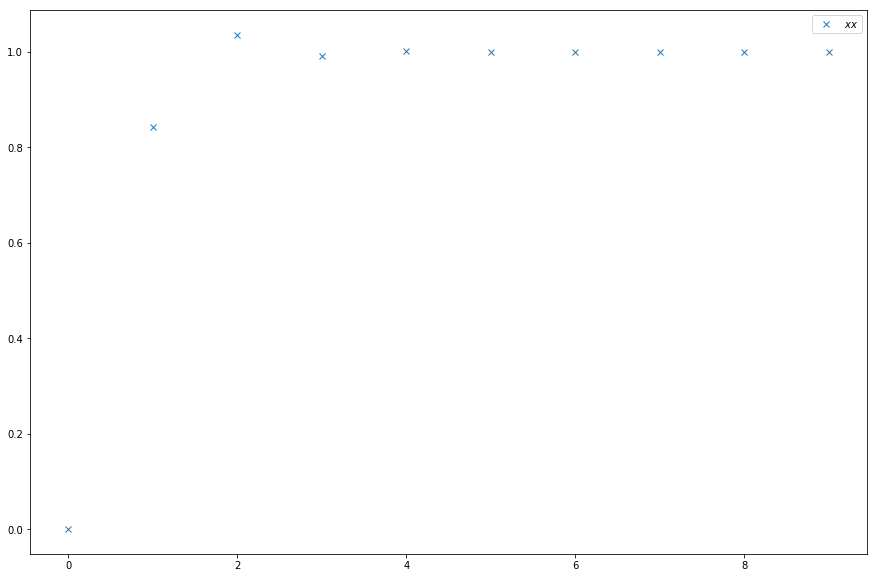

In [20]:
n_t = 10
plt.figure()
[t_range, OTOC_range] = evol(U, X, X, n_t)
plt.plot(t_range,OTOC_range.real,'x',label=r'$xx$')
plt.legend()
plt.show()

The long-time behaviour is fully determined by the eigenvectors with unit eigenvalue, and three of these can be explicitly constructed (representing unitarity, dual-unitarity, and an additional restriction similar to the action on a product state).

In [11]:
[E,_] = np.linalg.eig(tensor_to_matrix(T))
print("Eigenvalues of T: \n", np.sort(E))


#Check eigenstates
print("\nCheck known eigenstates\n")
e_1 = 1./q * np.einsum('abcdeffe->abcd',T)
#print("<e_1 | e_1>")
#print(np.linalg.norm(np.einsum('abcdefgh,efgh -> abcd',T,e_1)-e_1))

e_2 = 1./np.sqrt(q**2-1.)* ( np.einsum('abcdeeff->abcd',T) - 1./q * np.einsum('abcdeffe->abcd',T))
#print('T |e_2> - |e_2>')
#print(np.linalg.norm(np.einsum('abcdefgh,efgh -> abcd',T,e_2)-e_2))

e_3 = (np.einsum('abcdeeee -> abcd',T) - e_1 - np.sqrt((q-1.)/(q+1.)) * e_2) * np.sqrt((q+1)/(q-1)) / np.sqrt(q)
#print('T |e_3> - |e_3>')
#print(np.linalg.norm(np.einsum('abcdefgh,efgh -> abcd',T,e_3)-e_3))

eig_vecs = [e_1,e_2,e_3]

for eig_vec in eig_vecs:
    print(" || (T-1) | e_i > || = ", np.linalg.norm(contract_mv(T,eig_vec)-eig_vec))

#Check orthonormality
ov = np.zeros([3,3], dtype=complex)
for i, vec_i in enumerate(eig_vecs):
    for j, vec_j in enumerate(eig_vecs):
        ov[i,j] = contract_vv(vec_i,vec_j)
        
print("\nCheck orthonormality\n")
print(ov)

Eigenvalues of T: 
 [-2.2720e-01+1.2378e-16j -2.4794e-16+3.2223e-17j -1.9818e-16-5.9063e-18j
 -1.0325e-16+5.7323e-17j -2.8653e-17+1.2145e-16j -2.7643e-32-8.6736e-19j
  2.5653e-17-1.0689e-16j  1.3358e-16+7.9916e-17j  7.6608e-16-4.0535e-16j
  6.2161e-01+1.8178e-17j  6.2161e-01-4.3507e-17j  6.2161e-01-2.1208e-17j
  6.2161e-01+6.5371e-17j  1.0000e+00-6.0715e-18j  1.0000e+00+5.7707e-17j
  1.0000e+00-1.9912e-17j]

Check known eigenstates

 || (T-1) | e_i > || =  3.5219829497116673e-16
 || (T-1) | e_i > || =  2.1779241885078057e-16
 || (T-1) | e_i > || =  3.4053537421240315e-16

Check orthonormality

[[1.0000e+00+1.3010e-18j 5.5511e-17-7.0108e-18j 8.3267e-17+2.3016e-18j]
 [5.5511e-17-7.0108e-18j 1.0000e+00-1.0842e-17j 1.6653e-16-1.3800e-17j]
 [8.3267e-17+2.3016e-18j 1.6653e-16-1.3800e-17j 1.0000e+00-6.9389e-18j]]


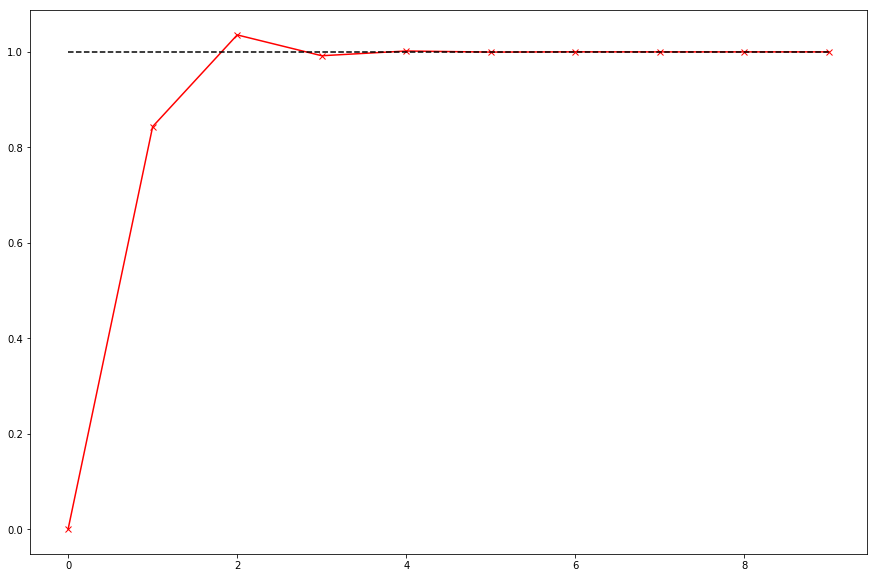

In [28]:
op_L, op_R = X, X
n_t = 10

[t_range, OTOC_range] = evol(U, op_L, op_R, n_t)
OTOC_f = 1. - np.sum([contract_vv(left_boundary(op_L),eig_vec)*contract_vv(eig_vec,right_boundary(op_R)) for eig_vec in eig_vecs])/q

plt.figure()
plt.plot(t_range,OTOC_range.real,'rx-')
plt.plot(t_range,[OTOC_f.real]*n_t,'k--')
plt.show()

The final values can be explicitly calculated as 1 for xx, 0 for zz, and 2 for zx. The only non-trivial behaviour seems to be for xx. 